# Loading dataset

In [1]:
# !curl -L -o ../data/CelebFaces/img-align-celeba.zip\
#     https://www.kaggle.com/api/v1/datasets/download/jessicali9530/celeba-dataset

In [1]:
import tensorflow as tf
from tensorflow.keras import utils
import typing as tp


# Process the image file
def preprocess(img):
    img = tf.cast(img, tf.float32) / 255.
    return img


# Load CelebA dataset from directory
def get_dataset(num_epochs: int,
                batch_size: int,
                image_size: tp.Sequence[int],
                valid_split: float):
    """The CelebA dataset loader"""

    train_ds, test_ds = utils.image_dataset_from_directory(
        directory="../data/CelebFaces/img_align_celeba/img_align_celeba",
        labels=None,
        color_mode='rgb',
        batch_size=None,
        image_size=image_size,
        interpolation='bilinear',
        validation_split=valid_split,
        seed=1024,
        subset='both'
    )

    train_ds = train_ds.map(lambda sample: preprocess(sample))
    train_ds = train_ds.repeat(num_epochs).shuffle(1024)
    train_ds = train_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    test_ds = test_ds.map(lambda sample: preprocess(sample))
    test_ds = test_ds.shuffle(1024)
    test_ds = test_ds.batch(batch_size, drop_remainder=True).prefetch(1)

    return train_ds, test_ds

In [2]:
input_shape = (64, 64, 3)
num_epochs = 15
batch_size = 128
valid_split = 0.2

train_ds, test_ds = get_dataset(
    num_epochs, batch_size, image_size=input_shape[:-1], valid_split=valid_split)
assert train_ds.take(1).element_spec.shape[1:] == input_shape

Found 202599 files.
Using 162080 files for training.
Using 40519 files for validation.


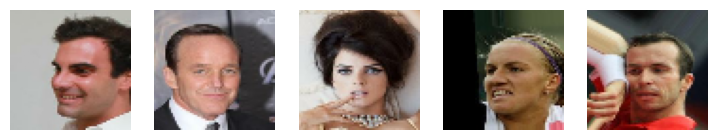

In [3]:
import matplotlib.pyplot as plt


def display(images, n=10, size=(9,7), cmap="gray_r", as_type="float32", save_to=None, style="seaborn-v0_8"):
    """
    Displays n random images from each one of the supplied arrays.
    """
    plt.style.use(style)

    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0


    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        img =  images[i]
        plt.imshow(img.astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:
        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()


samples = next(train_ds.as_numpy_iterator())
display(samples, n=5)

# Define the model

In [4]:
dim_latent = 200

In [5]:
import functools as ft

compose = lambda *fs: ft.reduce(lambda f, g: lambda x: g(f(x)), fs)  # function composition
mapply = lambda *fs: lambda x: (f(x) for f in fs)  # multple function application

In [6]:
import jax
import jax.numpy as jnp
from flax import nnx
import typing as tp


# Reparameterization trick
def reparameterize(key, mean, logvar):
    std = jnp.exp(0.5 * logvar)
    eps = jax.random.normal(key, logvar.shape)
    return mean + eps * std


@nnx.vmap
def kl_divergence(mean, logvar):
    return - 0.5 * jnp.sum(1 + logvar - jnp.power(mean, 2) - jnp.exp(logvar))


class Loss(nnx.Variable):
    pass


class Reparameterization(nnx.Module):

    def __init__(self, *, rngs: nnx.Rngs):
        self.rngs = rngs

    def __call__(self, mean: jax.Array, logvar: jax.Array):
        std = jnp.exp(0.5 * logvar)
        key = self.rngs()
        eps = jax.random.normal(key, logvar.shape)
        return mean + eps * std


class ConvBlock(nnx.Module):

    def __init__(self, dim_in: int, dim_out: int, *, activation: tp.Callable, rngs: nnx.Rngs):
        self.layers = [
            nnx.Conv(in_features=dim_in, out_features=dim_out, kernel_size=(3, 3), strides=2, rngs=rngs),
            nnx.BatchNorm(num_features=dim_out, rngs=rngs),
            activation
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)


class Encoder(nnx.Module):

    def __init__(self,
                 dim_in: int,
                 dim_out: int,
                 *,
                 features: tp.Sequence[int],
                 activation: tp.Callable,
                 rngs: nnx.Rngs):

        features = [dim_in] + list(features)

        self.layers = [
            ConvBlock(dim_in=features[i], dim_out=features[i+1], activation=activation, rngs=rngs)
            for i in range(len(features) - 1)
        ]
        self.layers += lambda x: x.reshape(x.shape[0], -1),  # flatten

        self.linear_mean = nnx.Linear(in_features=256, out_features=dim_out, rngs=rngs)
        self.linear_logvar = nnx.Linear(in_features=256, out_features=dim_out, rngs=rngs)
        self.reparameterize = Reparameterization(rngs=rngs.noise)

    def __call__(self, x: jax.Array) -> jax.Array:
        mean_x, logvar_x = compose(
            compose(*self.layers),
            mapply(self.linear_mean, self.linear_logvar)
        )(x)
        z =  self.reparameterize(mean_x, logvar_x)
        self.kl_loss = Loss(kl_divergence(mean_x, logvar_x))
        return z

In [7]:
encoder = Encoder(
    dim_in=input_shape[-1],
    dim_out=dim_latent,
    features=[64]*5,
    activation=nnx.leaky_relu,
    rngs=nnx.Rngs(0, noise=1)
)

encoder(jnp.ones([batch_size, *input_shape])).shape

Platform 'METAL' is experimental and not all JAX functionality may be correctly supported!
W0000 00:00:1736828792.934853 17207363 mps_client.cc:510] WARNING: JAX Apple GPU support is experimental and not all JAX functionality is correctly supported!
I0000 00:00:1736828792.943277 17207363 service.cc:145] XLA service 0x16b759cd0 initialized for platform METAL (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1736828792.943286 17207363 service.cc:153]   StreamExecutor device (0): Metal, <undefined>
I0000 00:00:1736828792.944565 17207363 mps_client.cc:406] Using Simple allocator.
I0000 00:00:1736828792.944574 17207363 mps_client.cc:384] XLA backend will use up to 51539214336 bytes on device 0 for SimpleAllocator.


Metal device set to: Apple M2 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



(128, 200)

In [8]:
class ConvTransposeBlock(nnx.Module):

    def __init__(self, dim_in: int, dim_out: int, *, activation: tp.Callable, rngs: nnx.Rngs):
        self.layers = [
            nnx.ConvTranspose(in_features=dim_in, out_features=dim_out, kernel_size=(3, 3), strides=(2,2), rngs=rngs),
            nnx.BatchNorm(num_features=dim_out, rngs=rngs),
            activation
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)


class LinearBlock(nnx.Module):

    def __init__(self, dim_in: int, dim_out: int, *, activation: tp.Callable, rngs: nnx.Rngs):
        self.layers = [
            nnx.Linear(in_features=dim_in, out_features=dim_out, rngs=rngs),
            nnx.BatchNorm(num_features=dim_out, rngs=rngs),
            activation
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)


class Decoder(nnx.Module):

    def __init__(self,
                 dim_in: int,
                 dim_out: int,
                 *,
                 features: tp.Sequence[int],
                 activation: tp.Callable,
                 rngs: nnx.Rngs):

        features = list(features) + [dim_out]

        self.layers = [
            LinearBlock(dim_in, 256, activation=activation, rngs=rngs),
            lambda x: x.reshape(x.shape[0], 2, 2, -1),  # unflatten
        ] + [
            ConvTransposeBlock(dim_in=features[i], dim_out=features[i+1], activation=activation, rngs=rngs)
            for i in range(len(features) - 1)
        ] + [
            nnx.Conv(in_features=features[-1], out_features=dim_out, kernel_size=(3,3), strides=1, rngs=rngs),
            nnx.sigmoid
        ]

    def __call__(self, x: jax.Array) -> jax.Array:
        return compose(*self.layers)(x)

In [9]:
decoder = Decoder(
    dim_in=dim_latent,
    dim_out=input_shape[-1],
    features=[64]*5,
    activation=nnx.relu,
    rngs=nnx.Rngs(0))

decoder(jnp.ones([batch_size, dim_latent])).shape

(128, 64, 64, 3)

# Variational AutoEncoder

In [10]:
class VAE(nnx.Module):

    def __init__(self,
                 dim_in: int,
                 dim_emb: int,
                 output_shape: tp.Sequence[int],
                 *,
                 features: tp.Sequence[int],
                 activation: tp.Callable,
                 rngs: nnx.Rngs):

        self.encoder = Encoder(dim_in, dim_emb, features=features, activation=activation, rngs=rngs)
        self.decoder = Decoder(dim_emb, dim_in, features=features, activation=activation, rngs=rngs)
        self.output_shape = output_shape

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.decoder(x)

    def generate(self, x):
        logits = self.decode(x)
        logits = jnp.reshape(logits, (-1, *self.output_shape))
        # return nnx.sigmoid(logits)
        return logits

    def __call__(self, x: jax.Array) -> jax.Array:
        logits = compose(self.encode, self.decode)(x)
        logits = jnp.reshape(logits, (-1, *self.output_shape))
        return logits

In [11]:
model = VAE(
    dim_in=input_shape[-1],
    dim_emb=dim_latent,
    output_shape=input_shape,
    features=[64]*5,
    activation=nnx.leaky_relu,
    rngs=nnx.Rngs(0, noise=1))

model.set_attributes(use_running_average=False)
nnx.display(model)

VAE(
  encoder=Encoder(
    layers=[ConvBlock(
      layers=[Conv(
        kernel_shape=(3, 3, 3, 64),
        kernel=Param(
          value=Array(shape=(3, 3, 3, 64), dtype=float32)
        ),
        bias=Param(
          value=Array(shape=(64,), dtype=float32)
        ),
        in_features=3,
        out_features=64,
        kernel_size=(3, 3),
        strides=2,
        padding='SAME',
        input_dilation=1,
        kernel_dilation=1,
        feature_group_count=1,
        use_bias=True,
        mask=None,
        dtype=None,
        param_dtype=<class 'jax.numpy.float32'>,
        precision=None,
        kernel_init=<function variance_scaling.<locals>.init at 0x16cc4c400>,
        bias_init=<function zeros at 0x141a42d40>,
        conv_general_dilated=<function conv_general_dilated at 0x141463d80>
      ), BatchNorm(
        mean=BatchStat(
          value=Array(shape=(64,), dtype=float32)
        ),
        var=BatchStat(
          value=Array(shape=(64,), dtype=float32)
    

In [12]:
import jax.numpy as jnp

model(jnp.ones([batch_size, *input_shape])).shape

(128, 64, 64, 3)

# Optimizer

In [13]:
import optax

learning_rate=5e-4
optimizer = nnx.Optimizer(model, optax.adam(learning_rate))

metrics =  nnx.MultiMetric(
    loss=nnx.metrics.Average("loss"),
    mse_loss=nnx.metrics.Average("mse_loss"),
    kl_loss=nnx.metrics.Average("kl_loss"),
)
nnx.display(metrics)

MultiMetric(
  loss=Average(
    argname='loss',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  ),
  mse_loss=Average(
    argname='mse_loss',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  ),
  kl_loss=Average(
    argname='kl_loss',
    total=MetricState(
      value=Array(0., dtype=float32)
    ),
    count=MetricState(
      value=Array(0, dtype=int32)
    )
  )
)


# Define training steps

In [26]:
beta = 1

def loss_fn(model: VAE, batch: jax.Array):
    logits = model(batch)
    losses = nnx.pop(model, Loss)
    kl_loss = jnp.mean(jnp.asarray(
        jax.tree_util.tree_leaves(losses)
    ))
    mse_loss = jnp.mean(
        optax.l2_loss(logits, batch)
    )
    loss = mse_loss + beta * kl_loss
    return loss, (mse_loss, kl_loss)

In [27]:
@nnx.jit
def train_step(model: VAE, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch: jax.Array):
    grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
    (loss, (mse_loss, kl_loss)), grads = grad_fn(model, batch)
    metrics.update(loss=loss, mse_loss=mse_loss, kl_loss=kl_loss)
    optimizer.update(grads)

@nnx.jit
def eval_step(model: VAE, metrics: nnx.MultiMetric, batch: jax.Array):
    (loss, (mse_loss, kl_loss)) = loss_fn(model, batch)
    metrics.update(loss=loss, mse_loss=mse_loss, kl_loss=kl_loss)

# Train and evaluate the model

In [28]:
import time

metrics_history = {
    "train_loss":  [],
    "train_mse_loss": [],
    "train_kl_loss": [],
    "test_loss": [],
    "test_mse_loss": [],
    "test_kl_loss": [],
}

num_steps_per_epoch = train_ds.cardinality() // num_epochs

prev_time = time.time()
for step, batch in enumerate(train_ds.as_numpy_iterator(), start=1):


    train_step(model, optimizer, metrics, batch)

    if step % num_steps_per_epoch == 0:
        model.set_attributes(use_running_average=True)
        # Log the training metric.
        for metric, value in metrics.compute().items():
            metrics_history[f"train_{metric}"].append(value)
        value = metrics.compute()
        metrics.reset()  # Reset the metric for the test set.

        # Compute the metric on the test set after each training epoch.
        for test_batch in test_ds.as_numpy_iterator():
            eval_step(model, metrics, test_batch)

        # Log the test metric.
        for metric, value in metrics.compute().items():
            metrics_history[f"test_{metric}"].append(value)
        value = metrics.compute()
        metrics.reset()  # Reset the metric for the test set.

        curr_time = time.time()
        print('epoch {}: \tepoch time {:.2f} min'.format(
            step // num_steps_per_epoch,
            (curr_time - prev_time) / 60
        ))
        prev_time = curr_time

        print(
            f"\ttrain_mse_loss: {metrics_history['train_mse_loss'][-1]:.4f}",
            f"\ttrain_kl_loss: {metrics_history['train_kl_loss'][-1]:.4f}",
        )

        print(
            f"\ttest_mse_loss: {metrics_history['test_mse_loss'][-1]:.4f}",
            f"\ttest_kl_loss: {metrics_history['test_kl_loss'][-1]:.4f}",
        )

        model.set_attributes(use_running_average=False)

epoch 1: 	epoch time 0.52 min
	train_mse_loss: 0.0595 	train_kl_loss: 0.0000
	test_mse_loss: 0.0498 	test_kl_loss: -0.0000


KeyboardInterrupt: 

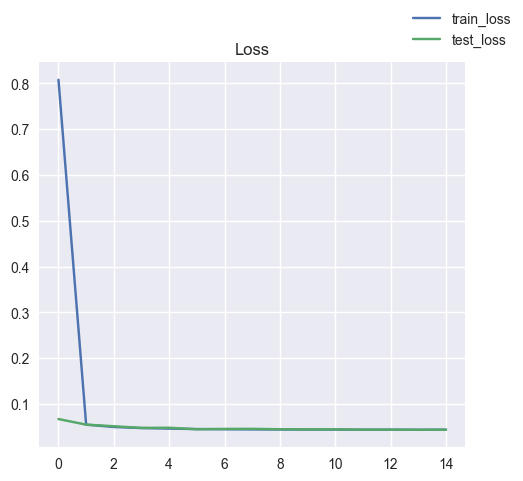

In [17]:
import matplotlib.pyplot as plt  # Visualization

# Plot loss and accuracy in subplots
fig = plt.figure(figsize=(5.5, 5))
plt.title('Loss')
for dataset in ('train', 'test'):
    plt.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
fig.legend()
plt.show()

# Reconstruction

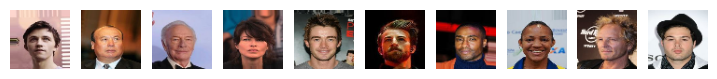

In [19]:
model.set_attributes(use_running_average=True)

test_examples = test_batch
display(test_examples)

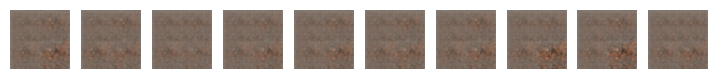

In [20]:
reconstructions = model(test_examples)
display(reconstructions)

# Reconstruction

In [23]:
import numpy as np


def get_samples(ds, num_samples=10):
    example_images = []; example_labels = []
    for i, samples in enumerate(ds.as_numpy_iterator()):
        example_images.append(samples)

        if i*batch_size >= num_samples:
            break
    return np.vstack(example_images)[:n_to_predict]

n_to_predict = 5_000
example_images = get_samples(test_ds, num_samples=n_to_predict)

embeddings = model.encode(example_images)

/var/folders/1y/ss_yfq694jj6ylk_kr7v1b580000gn/T/ipykernel_94305/3030340580.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(


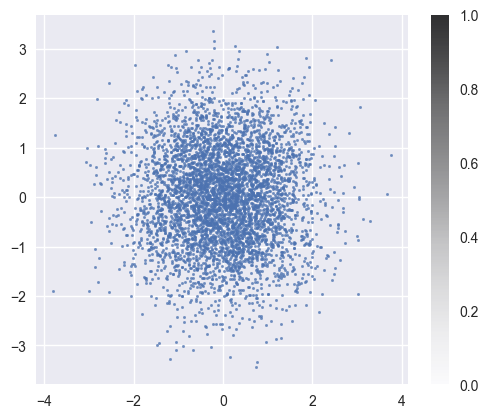

In [24]:
embeddings = model.encode(example_images)

figsize = 6
plt.figure(figsize=(figsize, figsize*0.8))
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    cmap="rainbow",
    alpha=0.8,
    s=3,
)
plt.colorbar()
plt.show()

## Generating new images

In [22]:
mins, maxs = np.min(embeddings, axis=0), np.max(embeddings, axis=0)

# Sample some points in the latent space
grid_width, grid_height = (5, 2)
samples = np.random.uniform(
    mins, maxs, size=(grid_width * grid_height, dim_latent)
)

In [ ]:
reconstructions = model.generate(samples).reshape(-1, *input_shape)
display(reconstructions)

In [ ]:
# Draw a plot of...
figsize = 5.5
plt.figure(figsize=(figsize, figsize))

# ... the original embeddings ...
plt.scatter(embeddings[:, 0], embeddings[:, 1], c=example_labels, cmap="rainbow", alpha=0.5, s=2)

# ... and the newly generated points in the latent space
plt.scatter(samples[:, 0], samples[:, 1], c="black", alpha=1, s=40)
plt.show()

# Add underneath a grid of the decoded images
fig = plt.figure(figsize=(figsize, grid_height))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.text(
        0.5,
        -0.35,
        str(np.round(samples[i, :], 1)),
        fontsize=10,
        ha="center",
        transform=ax.transAxes,
    )
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

# Latent space

In [ ]:
from scipy.stats import norm

p = norm.cdf(embeddings)
# p_sample = norm.cdf(z_samples)

plt.figure(figsize=(7, 6))
plt.scatter(p[:, 0],
            p[:, 1],
            cmap="rainbow",
            c=example_labels,
            alpha=0.8,
            s=3)
plt.colorbar()
plt.show()

In [26]:
sample_size = 14

x = norm.ppf(np.linspace(0.01, 0.99, sample_size))
y = norm.ppf(np.linspace(0.99, 0.01, sample_size))

xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
grid = np.array(list(zip(xv, yv)))

generated_imgs = model.generate(grid)

In [ ]:
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(hspace=0.2, wspace=0.2)
for i in range(sample_size**2):
    ax = fig.add_subplot(sample_size, sample_size, i + 1)
    ax.axis("off")
    ax.imshow(generated_imgs[i], cmap="gray")